In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
Nr = 400
alpha = 0.5
rho = 0.001
inputScaling = 1
biasScaling = 1
lam = 1
connectivity = 0.1

In [3]:
data = np.loadtxt("./Downloads/lienard_intermittency.dat")

In [4]:
train = data[:, 1][:45000]
test =  data[:, 1][45000:]

In [5]:
Win = np.random.uniform(-1, 1, (Nr, 1))
Wb = np.random.uniform(-1, 1, (Nr, 1)) 

In [6]:
def erdos_renyi(n=1000, p=0.1):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if np.random.uniform(0, 1) > p:
                a = np.random.uniform(-1, 1)
                A[i][j] = a
                A[j][i] = a
                
        A[i][i] = 0
            
    return A

In [7]:
Wres = erdos_renyi(400, 0.9)

In [8]:
np.sum(Wres!=0, axis=0).mean()

39.705

In [9]:
Wres = Wres*(rho/np.max(np.linalg.eig(Wres)[0]))

In [10]:
np.linalg.eig(Wres)[0].max()

0.0009999999999999961

In [11]:
def reservoir(U):
    r = np.random.uniform(1, -1, (Nr, 1))
    R = np.zeros((Nr, len(U)))
    R[:, 0] = r[:, 0]
    for i in range(1, len(U)):
        r = (1-alpha)*r + np.tanh(Wres@r + Win*U[i] + Wb) #U[i] is a number
        R[:, i] = r[:, 0]
    return R

In [12]:
R = reservoir(train)

In [13]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=1e-8)
reg.fit(R.T, train)

Ridge(alpha=1e-08)

In [14]:
def reservoir_step(r, v):
    return (1-alpha)*r + np.tanh(Wres@r + Win*v + Wb)

In [15]:
r = np.expand_dims(R[:, -1], axis=1)
def predict(r, v):
    r = reservoir_step(r, v)
    v_new = reg.predict(r.reshape((1, Nr)))
    return r, v_new

In [16]:
v = test[0]
predicted = []
rms = []
r = np.expand_dims(R[:, -1], axis=1)
r = reservoir_step(r, train[-1])
for i in range(len(test)):
    r, v = predict(r, test[i])            
           
    predicted.append(v)

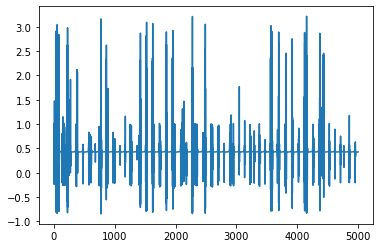

In [17]:
plt.plot(predicted)

In [18]:
predicted

[array([0.45249792]),
 array([0.46009083]),
 array([0.47188872]),
 array([0.49156849]),
 array([0.52913526]),
 array([0.6039077]),
 array([-0.23788611]),
 array([1.01558593]),
 array([0.59697748]),
 array([0.58607409]),
 array([-0.09119124]),
 array([1.47543976]),
 array([0.35344188]),
 array([0.29062472]),
 array([0.36303214]),
 array([0.40134968]),
 array([0.41998637]),
 array([0.42889735]),
 array([0.43320658]),
 array([0.43546177]),
 array([0.43688501]),
 array([0.43807377]),
 array([0.43933316]),
 array([0.44082563]),
 array([0.44269244]),
 array([0.44510492]),
 array([0.44829589]),
 array([0.45266897]),
 array([0.45894052]),
 array([0.46849082]),
 array([0.48427361]),
 array([0.51344557]),
 array([0.57436926]),
 array([-0.18524824]),
 array([0.43517845]),
 array([1.41929803]),
 array([-0.59440307]),
 array([2.68989052]),
 array([-0.81135988]),
 array([2.9117474]),
 array([-0.68610372]),
 array([1.5726689]),
 array([0.78519261]),
 array([0.4958206]),
 array([0.5370271]),
 array([-

In [19]:
test[:20]

array([ 0.45869201,  0.4654628 ,  0.47565613,  0.49247318,  0.52408408,
        0.58803211, -0.25650353,  1.04434093,  0.49227551,  0.58656699,
       -0.0628854 ,  1.55508694,  0.24027538,  0.39596374,  0.43495812,
        0.43644438,  0.43709203,  0.43778852,  0.43857093,  0.43946343])

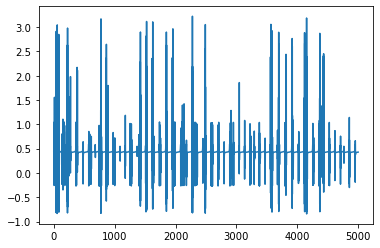

In [20]:
plt.plot(test)

In [21]:
(((np.array(predicted) - test)**2).mean())**0.5

0.46500147600332653